In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

In [2]:
df = pd.read_csv("../data/raw/bank/bank-full.csv", sep=";")

In [3]:
df['treatment'] = (df['housing'] == 'yes').astype(int)

In [4]:
X = df.drop(columns=['y', 'housing', 'treatment'])
y = df['treatment']

In [5]:
X = pd.get_dummies(X, drop_first=True)

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
logreg = LogisticRegression(solver='saga', max_iter=1000, random_state=42)
logreg.fit(X_scaled, y)
df['propensity_score'] = logreg.predict_proba(X_scaled)[:, 1]

In [8]:
def match_sample(df, caliper=0.05):
    treated = df[df['treatment'] == 1]
    control = df[df['treatment'] == 0]
    matched_control = []

    for _, row in treated.iterrows():
        potential_matches = control[np.abs(control['propensity_score'] - row['propensity_score']) <= caliper]
        if not potential_matches.empty:
            match = potential_matches.sample(1, random_state=42)
            matched_control.append(match)
            control = control.drop(match.index)

    matched_control = pd.concat(matched_control)
    return pd.concat([treated, matched_control])


In [9]:
matched_df_housing = match_sample(df.copy())
matched_df_housing['y_numeric'] = matched_df_housing['y'].map({'yes': 1, 'no': 0})

In [11]:
treated_matched = matched_df_housing[matched_df_housing['treatment'] == 1]
control_matched = matched_df_housing[matched_df_housing['treatment'] == 0]

treated_mean = treated_matched['y_numeric'].mean()
control_mean = control_matched['y_numeric'].mean()

att = treated_mean - control_mean
print(f"ATT (Housing Treatment): {att:.4f}")

ATT (Housing Treatment): -0.0723


In [12]:
t_stat, p_val = ttest_ind(treated_matched['y_numeric'], control_matched['y_numeric'])
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")


T-statistic: -21.6412
P-value: 0.0000


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

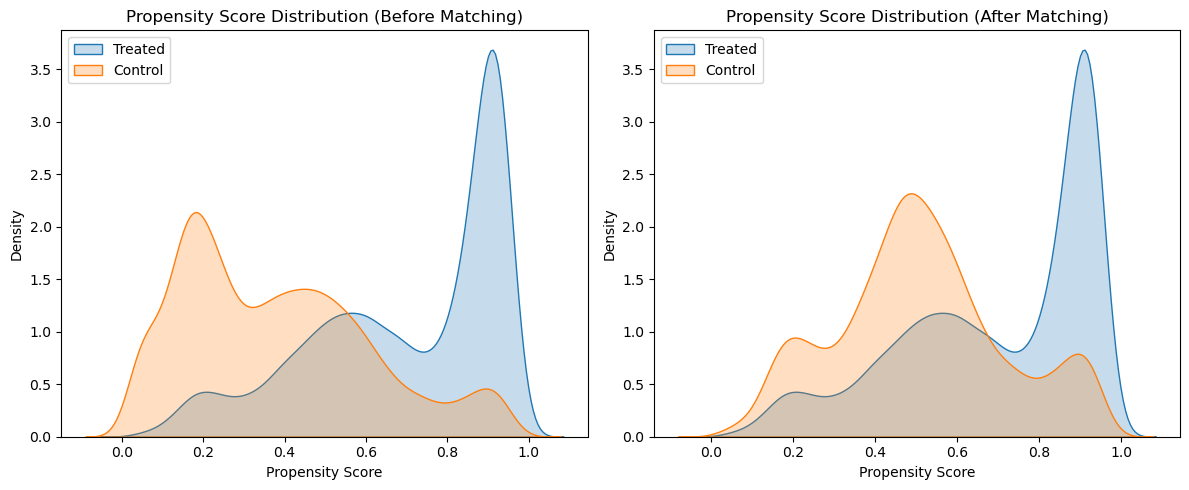

In [13]:
plt.figure(figsize=(12, 5))

# Before Matching
plt.subplot(1, 2, 1)
sns.kdeplot(df[df['treatment'] == 1]['propensity_score'], label='Treated', fill=True)
sns.kdeplot(df[df['treatment'] == 0]['propensity_score'], label='Control', fill=True)
plt.title('Propensity Score Distribution (Before Matching)')
plt.xlabel('Propensity Score')
plt.legend()

# After Matching
plt.subplot(1, 2, 2)
sns.kdeplot(matched_df_housing[matched_df_housing['treatment'] == 1]['propensity_score'], label='Treated', fill=True)
sns.kdeplot(matched_df_housing[matched_df_housing['treatment'] == 0]['propensity_score'], label='Control', fill=True)
plt.title('Propensity Score Distribution (After Matching)')
plt.xlabel('Propensity Score')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
matched_df_housing.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'treatment', 'propensity_score',
       'y_numeric'],
      dtype='object')

In [19]:
matched_df_housing[['treatment','propensity_score']].sample(5,random_state=42)

,treatment,propensity_score
1052,1,0.677926
30095,1,0.509070
29983,0,0.191940
6001,1,0.878648
26542,0,0.674918
